In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import datetime
import operator
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import csv

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

import re

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import pickle
import gensim

import itertools
import tensorflow as tf
import seaborn as sns
pal = sns.color_palette()

from keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
import wandb
from wandb.keras import WandbCallback

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# Embedding_File = 'glove.txt'
Train_Data_File = 'glue_data/MRPC/msr_paraphrase_train.txt'
Test_Data_File = 'glue_data/MRPC/msr_paraphrase_test.txt'
embedding_dim = 100
max_seq_length = 128
batch_size = 100
n_epoch = 50
n_hidden = 64

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harshalgoyal916. Use `wandb login --relogin` to force relogin


True

In [4]:
use_wandb = True
wandb__project_name = "Paraphrase Detection version 2"

# Functions

In [5]:
def extract_sentences():
    """
    Extract sentences for making word2vec model.
    """
    df1 = pd.read_csv(Train_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
    df2  = pd.read_csv(Test_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
    cols = ['isSimilar', 'SentenceID1', 'SentenceID2', 'Sentence1', 'Sentence2']
    df1.columns = cols
    df2.columns = cols

    for dataset in [df1, df2]:
        for i, row in dataset.iterrows():
            if row['Sentence1']:
                yield gensim.utils.simple_preprocess(row['Sentence1'])
            if row['Sentence2']:
                yield gensim.utils.simple_preprocess(row['Sentence2'])


documents = list(extract_sentences())

model = gensim.models.Word2Vec(documents)
model.train(documents, total_examples=len(documents), epochs=10)
model.save("ML_Model/mrpc.w2v")

In [6]:
def text_to_word_list(text):
    # Pre process and convert texts to a list of words
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [7]:
def make_w2v_embeddings(df, embedding_dim=50):
    vocabs = {}
    vocabs_cnt = 0

    vocabs_not_w2v = {}
    vocabs_not_w2v_cnt = 0

    # Stopwords
    stops = set(stopwords.words('english'))

    # Load word2vec
    word2vec = gensim.models.word2vec.Word2Vec.load("ML_Model/mrpc.w2v").wv
    for index, row in df.iterrows():
        # Print the number of embedded sentences.
        if index != 0 and index % 1000 == 0:
            print("{:,} sentences embedded.".format(index), flush=True)

        # Iterate through the text of both sentences of the row
        for sentence in ['Sentence1', 'Sentence2']:

            s2n = []
            for word in text_to_word_list(row[sentence]):
                # Check for unwanted words
                if word in stops:
                    continue

                # If a word is missing from word2vec model.
                if word not in word2vec.index_to_key:
                    if word not in vocabs_not_w2v:
                        vocabs_not_w2v_cnt += 1
                        vocabs_not_w2v[word] = 1

                # If you have never seen a word, append it to vocab dictionary.
                if word not in vocabs:
                    vocabs_cnt += 1
                    vocabs[word] = vocabs_cnt
                    s2n.append(vocabs_cnt)
                else:
                    s2n.append(vocabs[word])

            # Append sentence as number representation
            df.at[index, sentence + '_n'] = s2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # This will be the embedding matrix
    embeddings[0] = 0  # So that the padding will be ignored

    # Build the embedding matrix
    for word, index in vocabs.items():
        if word in word2vec.index_to_key:
            embeddings[index] = word2vec.word_vec(word)
    del word2vec

    return df, embeddings

In [8]:
def split_and_zero_padding(df, max_seq_length):
    # Split to dicts
    X = {'left': df['Sentence1_n'], 'right': df['Sentence2_n']}

    # Zero padding
    for dataset, side in itertools.product([X], ['left', 'right']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset

In [9]:
class ManDist(Layer):
    """
    Keras Custom Layer that calculates Manhattan Distance.
    """

    # initialize the layer, No need to include inputs parameter!
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # input_shape will automatic collect input shapes to build layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # This is where the layer's logic lives.
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return output shape
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [10]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

In [11]:
def word_shares(row):
    stops = set(stopwords.words('english'))
    q1 = set(str(row['Sentence1']).lower().split())
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0'

    q2 = set(str(row['Sentence2']).lower().split())
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0'

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    return '{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32)

# EDA

In [12]:
df_train = pd.read_csv(Train_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
df_test  = pd.read_csv(Test_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
cols = ['isSimilar', 'SentenceID1', 'SentenceID2', 'Sentence1', 'Sentence2']
df_train.columns = cols
df_test.columns = cols

In [13]:
df_train.head()

,isSimilar,SentenceID1,SentenceID2,Sentence1,Sentence2
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


In [14]:
df_test.head()

,isSimilar,SentenceID1,SentenceID2,Sentence1,Sentence2
0,1,1089874,1089925,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...
1,1,3019446,3019327,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...
2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,0,3354381,3354396,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...


In [15]:
Counter(df_train['isSimilar'])

Counter({1: 2753, 0: 1323})

In [16]:
print('Total number of sentence pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['isSimilar'].mean()*100, 2)))
sids = pd.Series(df_train['SentenceID1'].tolist() + df_train['SentenceID2'].tolist())
print('Total number of sentences in the training data: {}'.format(len(
    np.unique(sids))))
print('Number of sentences that appear multiple times: {}'.format(np.sum(sids.value_counts() > 1)))



Total number of sentence pairs for training: 4076
Duplicate pairs: 67.54%
Total number of sentences in the training data: 7817
Number of sentences that appear multiple times: 308


Most sentences occur only once, but there are a few sentences that occur more than once.

mean-train 118.73 std-train 33.37 mean-test 118.20 std-test 33.49 max-train 226.00 max-test 222.00


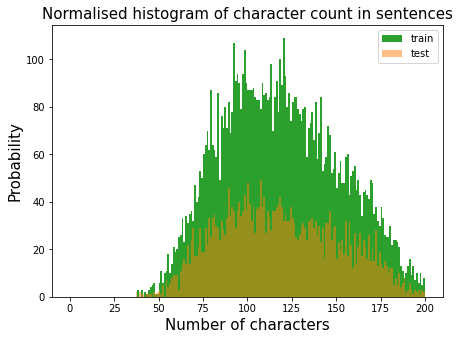

In [17]:
train_s = pd.Series(df_train['Sentence1'].tolist() + df_train['Sentence2'].tolist()).astype(str)
test_s = pd.Series(df_test['Sentence1'].tolist() + df_test['Sentence2'].tolist()).astype(str)

dist_train = train_s.apply(len)
dist_test = test_s.apply(len)
plt.figure(figsize=(7, 5))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], alpha=0.5, label='test')
plt.title('Normalised histogram of character count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

Most sentences are long, with a few exceptions with less than 50 characters.

mean-train 21.95 std-train 5.65 mean-test 21.75 std-test 5.66 max-train 42.00 max-test 36.00


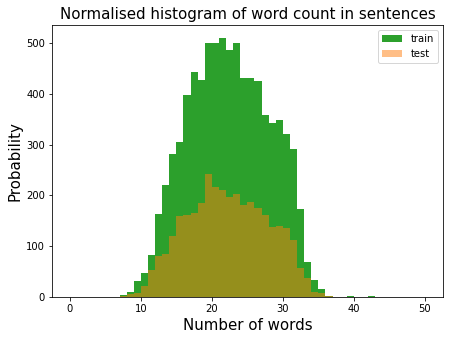

In [18]:
dist_train = train_s.apply(lambda x: len(x.split(' ')))
dist_test = test_s.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(7, 5))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], alpha=0.5, label='test')
plt.title('Normalised histogram of word count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

Similar trend in number of words, good thing that both train and test sets are even in length in terms of sentences.

(-0.5, 1439.5, 1079.5, -0.5)

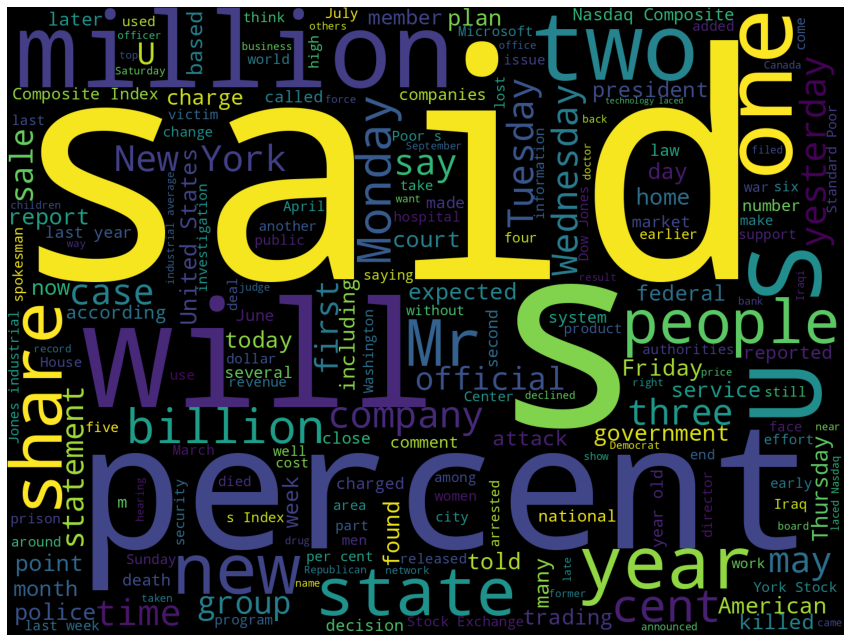

In [19]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_s.astype(str)))
plt.figure(figsize=(15, 15))
plt.imshow(cloud)
plt.axis('off')

The text seems to be mostly related to US, people saying something and timeframe of some event.

# Data Preprocessing

## XGB

In [20]:
train_qs = pd.Series(df_train['Sentence1'].tolist() + df_train['Sentence2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [21]:
# import json
# json.dump(weights, open("ML_Model/weights.json", 'w'))

In [22]:
df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1)

In [23]:
df.head()

,isSimilar,SentenceID1,SentenceID2,Sentence1,Sentence2,word_shares
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",0.44941188882766286:0.45454545454545453:10:0.4...
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0.3098362137704298:0.3076923076923077:8:0.4166...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",0.36686127331943186:0.375:9:0.6363636363636364...
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0.34450940598987234:0.3333333333333333:11:0.38...
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,0.2799575000686463:0.25806451612903225:8:0.428...


In [24]:
x = pd.DataFrame()

x['word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count'] = df['word_shares'].apply(lambda x: float(x.split(':')[2]))
x['stops1_ratio'] = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio'] = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['diff_stops_r'] = x['stops1_ratio'] - x['stops2_ratio']

x['len_s1'] = df['Sentence1'].apply(lambda x: len(str(x)))
x['len_s2'] = df['Sentence2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_s1'] - x['len_s2']

x['len_char_s1'] = df['Sentence1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_s2'] = df['Sentence2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_s1'] - x['len_char_s2']

x['len_word_s1'] = df['Sentence1'].apply(lambda x: len(str(x).split()))
x['len_word_s2'] = df['Sentence2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_s1'] - x['len_word_s2']

x['avg_world_len1'] = x['len_char_s1'] / x['len_word_s1']
x['avg_world_len2'] = x['len_char_s2'] / x['len_word_s2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['Sentence1'] == df['Sentence2']).astype(int)
x['duplicated'] = df.duplicated(['Sentence1','Sentence2']).astype(int)

In [25]:
X = x[:df_train.shape[0]]
x_val  = x[df_train.shape[0]:]
y = df_train['isSimilar'].values

In [26]:
x_val.head()

,word_match,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,diff_stops_r,len_s1,len_s2,diff_len,len_char_s1,len_char_s2,diff_len_char,len_word_s1,len_word_s2,diff_len_word,avg_world_len1,avg_world_len2,diff_avg_word,exactly_same,duplicated
0,0.368428,0.370370,10.0,0.333333,0.333333,0.000000,127,109,18,103,92,11,25,18,7,4.120000,5.111111,-0.991111,0,0
1,0.246250,0.236842,9.0,0.400000,0.388889,0.011111,179,161,18,149,135,14,31,27,4,4.806452,5.000000,-0.193548,0,0
2,0.346610,0.352941,12.0,0.380952,0.538462,-0.157509,161,122,39,131,101,30,31,22,9,4.225806,4.590909,-0.365103,0,0
3,0.371492,0.361111,13.0,0.529412,0.473684,0.055728,151,172,-21,125,144,-19,27,29,-2,4.629630,4.965517,-0.335888,0,0
4,0.251537,0.235294,4.0,0.571429,0.500000,0.071429,69,100,-31,57,83,-26,13,18,-5,4.384615,4.611111,-0.226496,0,0


In [27]:
y_val = df_test['isSimilar'].values
Counter(y_val)

Counter({1: 1147, 0: 578})

## LSTM

In [28]:
train_df = pd.read_csv(Train_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
test_df  = pd.read_csv(Test_Data_File, sep='\t', quoting=csv.QUOTE_NONE)
cols = ['isSimilar', 'SentenceID1', 'SentenceID2', 'Sentence1', 'Sentence2']
train_df.columns = cols
test_df.columns = cols

In [29]:
for s in ['Sentence1', 'Sentence2']:
    train_df[s + '_n'] = train_df[s]
    
for s in ['Sentence1', 'Sentence2']:
    test_df[s + '_n'] = test_df[s]

In [30]:
train_df, embeddings = make_w2v_embeddings(train_df, embedding_dim=embedding_dim)

1,000 sentences embedded.
2,000 sentences embedded.
3,000 sentences embedded.
4,000 sentences embedded.


In [31]:
test_df, embeddings_test = make_w2v_embeddings(test_df, embedding_dim=embedding_dim)

1,000 sentences embedded.


In [32]:
X_test_lstm = split_and_zero_padding(test_df, max_seq_length)

In [33]:
validation_size = int(len(train_df) * 0.1)
training_size = len(train_df) - validation_size

X_lstm = train_df[['Sentence1_n', 'Sentence2_n']]
Y_lstm = train_df['isSimilar']

In [34]:
X_train_lstm, X_validation_lstm, Y_train_lstm, Y_validation_lstm = train_test_split(X_lstm, Y_lstm, test_size=validation_size)

In [35]:
X_train_lstm = split_and_zero_padding(X_train_lstm, max_seq_length)
X_validation_lstm = split_and_zero_padding(X_validation_lstm, max_seq_length)

In [36]:
Y_train_lstm = Y_train_lstm.values
Y_validation_lstm = Y_validation_lstm.values

# Model Training

## XGB

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [38]:
if use_wandb:
  wandb.init(project=wandb__project_name, name='XGBOOST_Model')

In [39]:
from wandb.xgboost import wandb_callback

In [40]:
xgb_clf = XGBClassifier(base_score=0.5, colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=5,
       min_child_weight=1, n_estimators=50, n_jobs=4, random_state=42)
xgb_clf.fit(X_train, y_train)
wandb.sklearn.plot_learning_curve(xgb_clf, X_train, y_train)

In [41]:
y_raw_pred = xgb_clf.predict_proba(X_test)[:,1]
y_pred = np.where(y_raw_pred > 0.5, 1, 0)
pred_prob = xgb_clf.predict_proba(X_test)[:,1]

In [42]:
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, xgb_clf.classes_)

In [43]:
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Recall: 0.8758620689655172
Precision: 0.7839506172839507
F1: 0.8273615635179152
Accuracy: 0.7401960784313726


## LSTM

In [44]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [45]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(embeddings), embedding_dim,
                weights=[embeddings], input_shape=(max_seq_length,), trainable=False))
model_lstm.add(LSTM(n_hidden, dropout=0.3))
shared_model = model_lstm

In [46]:
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

In [47]:
malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])

In [48]:
import keras.optimizers as optimizers

In [49]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [50]:
model.compile(loss='mean_squared_error', metrics=['accuracy'])
model.summary()
# shared_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           1338140     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
man_dist (ManDist)              (None, 1)            0           sequential[0][0]             

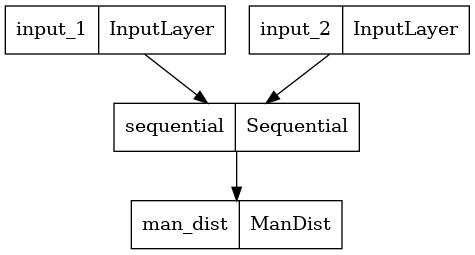

In [51]:
tf.keras.utils.plot_model(model)

In [52]:
early_stopping =EarlyStopping(monitor='val_loss', patience=5)

In [53]:
if use_wandb:
  wandb.init(project=wandb__project_name, name='LSTM_Model')

In [54]:
hist = model.fit([X_train_lstm['left'], X_train_lstm['right']], Y_train_lstm,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation_lstm['left'], X_validation_lstm['right']], Y_validation_lstm),
                 callbacks=[early_stopping,WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
37/37 [==============================] - 25s 376ms/step - loss: 0.6226 - accuracy: 0.3213 - val_loss: 0.3607 - val_accuracy: 0.5307
Epoch 2/50
37/37 [==============================] - 13s 352ms/step - loss: 0.4924 - accuracy: 0.3459 - val_loss: 0.2932 - val_accuracy: 0.5921
Epoch 3/50
37/37 [==============================] - 14s 364ms/step - loss: 0.3771 - accuracy: 0.4366 - val_loss: 0.2749 - val_accuracy: 0.6413
Epoch 4/50
37/37 [==============================] - 11s 305ms/step - loss: 0.3042 - accuracy: 0.5489 - val_loss: 0.2733 - val_accuracy: 0.6364
Epoch 5/50
37/37 [==============================] - 11s 297ms/step - loss: 0.2664 - accuracy: 0.6062 - val_loss: 0.2694 - val_accuracy: 0.6437
Epoch 6/50
37/37 [==============================] - 11s 309ms/step - loss: 0.2392 - accuracy: 0.6348 - val_loss: 0.2634 - val_accuracy: 0.6462
Epoch 7/50
37/37 [==============================] - 13s 341ms/step - loss: 0.2235 - accuracy: 0.6620 - val_loss: 0.2560 - val_accuracy: 0.6634

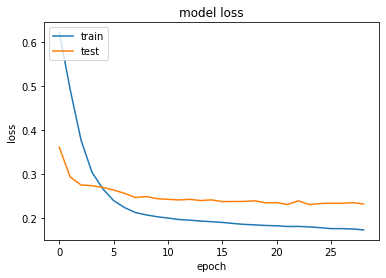

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test & Save Model

## XGB

In [56]:
y_raw_pred = xgb_clf.predict_proba(x_val)[:,1]
y_pred = np.where(y_raw_pred > 0.5, 1, 0)

In [57]:
print("Recall:", recall_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Recall: 0.8552746294681779
Precision: 0.744874715261959
F1: 0.7962662337662338
Accuracy: 0.7089855072463768


In [58]:
pickle.dump(xgb_clf, open("ML_Model/xgb_clf.pickle.dat", "wb"))

## LSTM

In [59]:
prediction = model.predict([X_test_lstm['left'], X_test_lstm['right']])

In [60]:
y_pred = np.where(prediction > 0.5, 1, 0)

In [61]:
print("Recall:", recall_score(test_df['isSimilar'], y_pred))
print("Precision:", precision_score(test_df['isSimilar'], y_pred))
print("F1:", f1_score(test_df['isSimilar'], y_pred))
print("Accuracy:", accuracy_score(test_df['isSimilar'], y_pred))

Recall: 0.9067131647776809
Precision: 0.6824146981627297
F1: 0.7787345563459378
Accuracy: 0.6573913043478261


In [62]:
model.save('ML_Model/SiameseLSTM.h5')